In [1]:
%matplotlib inline

##Question 6:


*   Build a CNN and optimize the accuracy for CIFAR-10. Try different number of layers and different architectures (depth and convolutional filter hyperparameters).
*   Is momentum and learning rate having a significant effect? Track the train and test loss across training epochs and plot them for different learning rates and momentum values.
*   Is the depth of the CNN having a significant effect on performance? Describe the hyperparameters of the best model you could train.

### Loading CIFAR-10 Dataset

In [2]:
# Loading Dataset libraries
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
# Computional and Graphical libraries
from matplotlib import pyplot
import numpy as np
import torch
# Debugger Library
from IPython.core.debugger import set_trace

# The CIFAR-10 Dataset loading steps are just from our Q.1
dataset = fetch_openml('CIFAR_10_small')

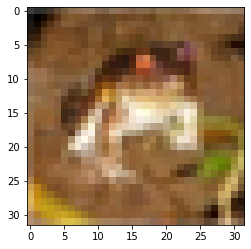

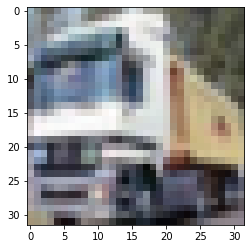

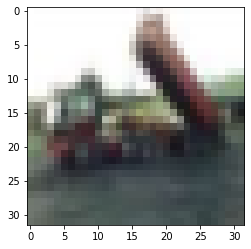

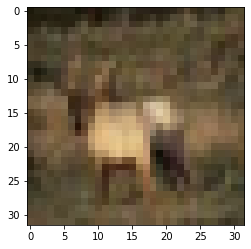

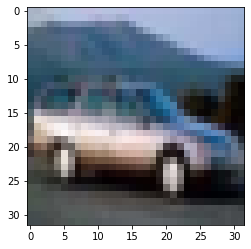

In [3]:
# Some images to make sure we loaded correctly
for i in range(5):
    pyplot.figure(i)
    
    img_raw = dataset['data'][i]
    r = img_raw[0:1024].reshape(32, 32)/255.0
    g = img_raw[1024:2048].reshape(32, 32)/255.0
    b = img_raw[2048:].reshape(32, 32)/255.0

    img = np.dstack((r, g, b))

    pyplot.imshow(img)

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(dataset['data'], dataset['target'], test_size=0.25)
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

### Classes and Functions

In [5]:
# Training and Validation Datasets/DataLoaders Libraries
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# Optim and NN libraries
from torch import optim
from torch import nn
import torch.nn.functional as F

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

loss_func = F.cross_entropy

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl)    #valid_loss / len(valid_dl)

        val_acc = val_acc.numpy()
        print(epoch, val_loss, val_acc / len(valid_dl))

# Accuracy check from Validation Test.
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x, y):
    return x.view(-1, 3, 32, 32), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

### Initial Variables

In [12]:
bs = 64  # batch size
lr = 0.1  # learning rate
epochs = 2  # how many epochs to train for
# a = np.zeros((20, 10), dtype=(float,5))

### Training and Validation Datasets/DataLoaders 


In [13]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

### Original Model, Optim (Use to do Foward Step), and Training

In [8]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model = model.double()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 2.302585092994041 0.10234375
1 2.302585092994041 0.10234375


### Training of Model. Outputs Validation Loss.


In [9]:
# 5 Conv Layers with just more fully connected layers 
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model = model.double()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

# Results show no difference

0 2.302585092994041 0.10234375
1 2.302585092994041 0.10234375


In [14]:
# 5 Conv Layers with pooling in between
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(8),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model = model.double()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

# Results still don't show any difference. That is weird.

0 2.302589890821974 0.10234375
1 2.302591762309042 0.10234375


In [11]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model = model.double()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 2.302585092994041 0.10234375
1 2.302585092994041 0.10234375


### Testing different learning rate and momentum values.


In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, mat, lr, momentum):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl)    #valid_loss / len(valid_dl)
        val_acc = val_acc.numpy() / len(valid_dl)
        mat_data = (epoch, lr, momentum, val_loss, val_acc)
        mat[int(((lr*20)-2)+epoch)][int(momentum*10)] = mat_data
        print(epoch, val_loss, val_acc)
    return mat
################################################################################
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
for x in range(10):           # Varying for LR from 0.1 to 1.0  
  lr = (x+1)/10
  for y in range(10):         # Varying for Momentum 0.0 to 0.9
    momentum = y/10
    opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    print(lr, momentum)
    a = fit(epochs, model, loss_func, opt, train_dl, valid_dl, a, lr, momentum)


0.1 0.0
0 1.3558262022018432 0.5522151898734177
1 0.8818770881652832 0.7006526898734177
0.1 0.1
0 0.507491164112091 0.8535403481012658
1 0.4231681248188019 0.8794501582278481
0.1 0.2
0 0.4765414839506149 0.8577927215189873
1 0.3212484186410904 0.9073378164556962
0.1 0.3
0 0.32180574489831926 0.8998219936708861
1 0.2865055351018906 0.9149525316455697
0.1 0.4
0 0.2334865667939186 0.9348299050632911
1 0.22433320047855376 0.9340387658227848
0.1 0.5
0 0.325609538435936 0.9042721518987342
1 0.23776539866924287 0.9268196202531646
0.1 0.6
0 0.19740060652196406 0.9406645569620253
1 0.2151036279141903 0.9362143987341772
0.1 0.7
0 0.20004336276352405 0.942246835443038
1 0.20228782544732093 0.9408623417721519
0.1 0.8
0 0.17519655836820602 0.9482792721518988
1 0.17256289960294963 0.9496637658227848
0.1 0.9
0 0.20380617601275444 0.935126582278481
1 0.15065279561281203 0.9550039556962026
0.2 0.0
0 0.14262626667022704 0.9608386075949367
1 0.11378676705956459 0.9658821202531646
0.2 0.1
0 0.116668946343

### Graphical Illustration of Accuracy for Varying Values of Learning Rate and Momentum

In [ ]:
def Largest_Moment(mat, index):
  best_Momentum_index = 0;
  for x in range(10):
    if(mat[index][x][4] > mat[index][best_Momentum_index][4]):
      best_Momentum_index = x
  return best_Momentum_index

mat_lr = np.zeros(20)
mat_moment = np.zeros(20)
mat_acc = np.zeros(20)

for i in range(20):
  mat_lr[i] = a[i][0][1]
  # Momentum index with greatest Accuracy of a given LR.
  large = Largest_Moment(a, i)
  mat_moment[i] = a[i][large][2]
  mat_acc[i] = a[i][large][4]

The arrays of LR, Momentum, and Accuracy should be counted in groups of 2. First Value is epoch 1, second value is epoch 2. Then LR/Momentum will increment. For example, below we see that the 8th value in accuracy array is the largest. This corresponds to a learning rate of 0.5 and momentum 0.4 and epoch 1. Loss of valiation sets are also shown as 0.9500714. 

In [ ]:
print(mat_acc)
print(mat_moment[8])
print(a[8][4])

[0.94827927 0.95500396 0.96815665 0.9674644  0.97448576 0.97458465
 0.97517801 0.97547468 0.97606804 0.97488133 0.97359573 0.97369462
 0.97221123 0.97349684 0.96192642 0.96340981 0.65773339 0.6614913
 0.73872627 0.7305182 ]
0.4
[0.         0.5        0.4        0.09500714 0.97606804]


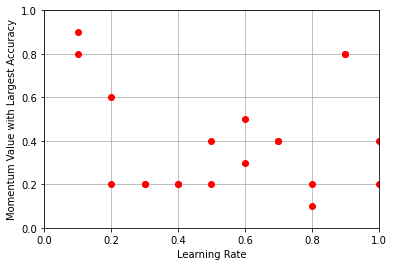

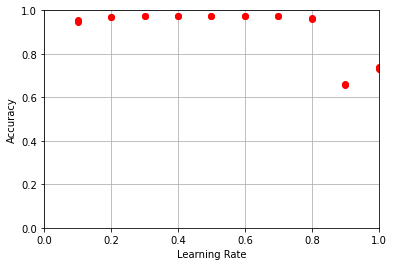

In [ ]:
fig, ax = pyplot.subplots()
ax.plot(mat_lr, mat_moment, 'ro')
ax.axis([0, 1, 0, 1])
ax.set(xlabel='Learning Rate', ylabel='Momentum Value with Largest Accuracy')
ax.grid()
pyplot.show()

fig, ax = pyplot.subplots()
ax.plot(mat_lr, mat_acc, 'ro')
ax.axis([0, 1, 0, 1])
ax.set(xlabel='Learning Rate', ylabel='Accuracy')
ax.grid()
pyplot.show()

From the plot above. We got our best accuracy, 0.97606804, with a learning rate of 0.5 and a momentum of 0.4. In the graphs above, every LR has two dots since there is 2 epochs.